## Flight data pytorch LSTM example

[flight-passengers-prediction-LSTM/flight\_passengers\_prediction\_LSTM.ipynb at master · mikel-brostrom/flight-passengers-prediction-LSTM](https://github.com/mikel-brostrom/flight-passengers-prediction-LSTM/blob/master/flight_passengers_prediction_LSTM.ipynb)

not used but same dataset:

[LSTM for Time Series Prediction in PyTorch - MachineLearningMastery.com](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2025-02-14 20:57:41--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv.1’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2025-02-14 20:57:41 (33.2 MB/s) - ‘airline-passengers.csv.1’ saved [2180/2180]



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

### View data

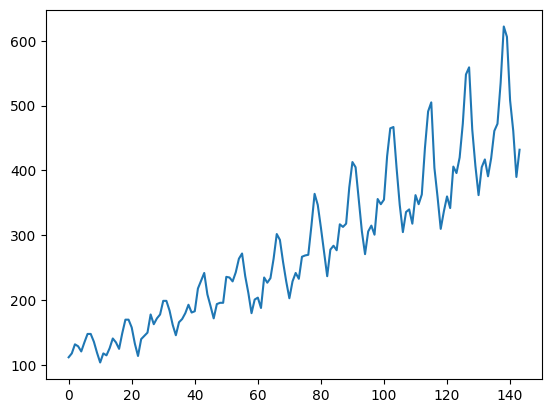

In [2]:
import pandas as pd
 
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

### Generate test and train data

In [3]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


In [4]:

import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
lookback = 12
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([84, 12, 1]) torch.Size([84, 12, 1])
torch.Size([36, 12, 1]) torch.Size([36, 12, 1])


/tmp/ipykernel_49927/3930656702.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [10]:

import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

/tmp/ipykernel_49927/3411043597.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipykernel_49927/3411043597.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 221.8460, test RMSE 417.7717
Epoch 100: train RMSE 174.7320, test RMSE 368.7978
Epoch 200: train RMSE 137.3385, test RMSE 328.5715
Epoch 300: train RMSE 106.7263, test RMSE 293.3195
Epoch 400: train RMSE 84.0362, test RMSE 263.0782
Epoch 500: train RMSE 65.5826, test RMSE 236.5459
Epoch 600: train RMSE 49.1860, test RMSE 207.7213
Epoch 700: train RMSE 38.9870, test RMSE 185.0484
Epoch 800: train RMSE 31.4322, test RMSE 164.5200
Epoch 900: train RMSE 25.9993, test RMSE 146.6373
Epoch 1000: train RMSE 22.2750, test RMSE 131.6659
Epoch 1100: train RMSE 20.0632, test RMSE 119.7251
Epoch 1200: train RMSE 17.7246, test RMSE 108.8374
Epoch 1300: train RMSE 16.2693, test RMSE 101.1596
Epoch 1400: train RMSE 15.3467, test RMSE 94.8065
Epoch 1500: train RMSE 14.5570, test RMSE 88.9798
Epoch 1600: train RMSE 13.5169, test RMSE 85.3482
Epoch 1700: train RMSE 13.2489, test RMSE 83.5984
Epoch 1800: train RMSE 12.6762, test RMSE 81.0038
Epoch 1900: train RMSE 12.1536, test RMSE 81

/tmp/ipykernel_49927/3103842424.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  train_plot[lookback:train_size] = model(X_train)[:, -1, :]
/tmp/ipykernel_49927/3103842424.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


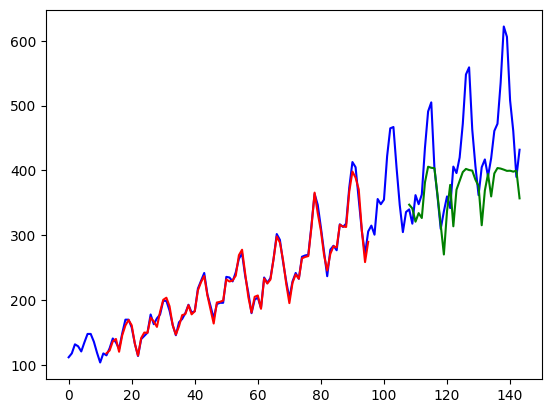

In [11]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()